In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
geo = 'GSE201257'
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_unzip = os.path.join(pth_data, 'unzip', geo)
pth_out = os.path.join(pth_data, 'processed')
pth_fig = os.path.join(pth, 'figures', 'preprocessing')

In [3]:
df_summary = pd.read_csv(os.path.join(pth_data, 'summary.csv'))
df_summary = df_summary.loc[df_summary.Source == geo]
df_summary

,Source,Name,Study,Species,Trajectory,Age,Description
2,GSE201257,Schwann Cell Precursor,"Kastriti et al, 2022",mmusculus,True,E9.5-Adult,Neural crest cell atlas describing diversifica...


In [4]:
fn = os.path.join(pth_unzip, f'{geo}_adata_assigned.h5ad')
adata = sc.read_h5ad(fn); adata

AnnData object with n_obs × n_vars = 8842 × 21676
    obs: 'plates', 'devtime', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'leiden', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'Hub_colors', 'assignments_colors', 'devtime_colors', 'leiden', 'leiden_colors', 'leiden_sizes', 'location_colors', 'log1p', 'neighbors', 'paga', 'umap'
    obsm: 'X_diff', 'X_pca', 'X_umap'
    layers: 'palantir_imp', 'scaled'
    obsp: 'connectivities', 'distances'

In [ ]:
sc.pl.umap(adata, color = ['devtime', 'location', 'assignments', 'Hub', 'leiden'])

In [5]:
celltype_dict = {
    'BCC'         : 'Boundary Cap Cell',
    'ChC'         : 'Chromaffin Cell',
    'Gut_glia'    : 'Enteric Glia',
    'Gut_neuron'  : 'Enteric Neuron',
    'Melanocytes' : 'Melanocyte',
    'Mesenchyme'  : 'Cranial Mesenchyme',
    'NCC'         : 'Neural Crest Cell',
    'SC'          : 'Schwann Cell',
    'SatGlia'     : 'Satelite Glia',
    'Sensory'     : 'Sensory Neuron',
    'Symp'        : 'Sympathetic Neuron',
    'enFib'       : 'Endoneurial Fibroblast'}

adata.obs['celltype'] = adata.obs.assignments.map(celltype_dict).astype('category')
cat = ['Schwann Cell Precursor Hub', 'Cranial Neural Crest', 'Trunk Neural Crest']
adata.obs.celltype = adata.obs.celltype.cat.add_categories(cat)
adata.obs.loc[(adata.obs.Hub == 'True'), 'celltype'] = 'Schwann Cell Precursor Hub'
adata.obs.loc[(adata.obs.celltype == 'Neural Crest Cell') & (adata.obs.leiden == '2'), 'celltype'] = 'Cranial Neural Crest'
adata.obs.loc[(adata.obs.celltype == 'Neural Crest Cell'), 'celltype'] = 'Trunk Neural Crest'
adata.obs.celltype = adata.obs.celltype.cat.remove_categories(['Neural Crest Cell'])

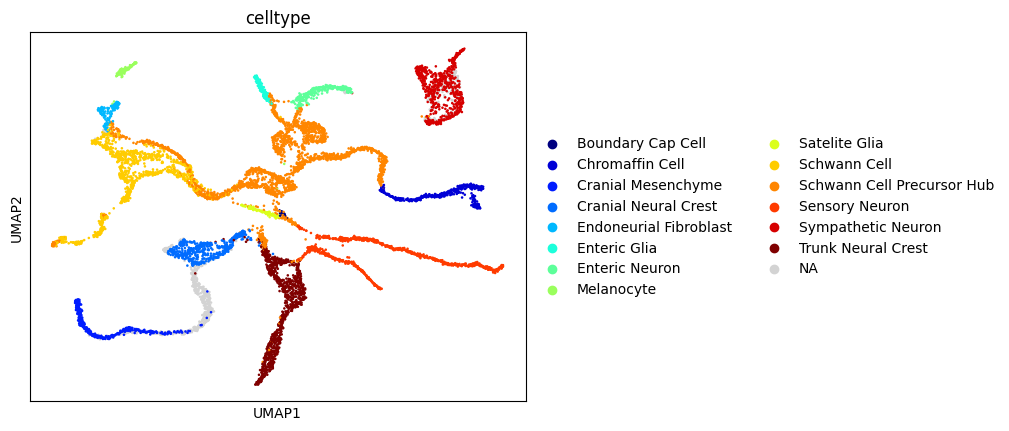

In [6]:
sc.pl.umap(adata, color = 'celltype', palette = 'jet')

In [7]:
adata.write(os.path.join(pth_out, f'{geo}.h5ad'))

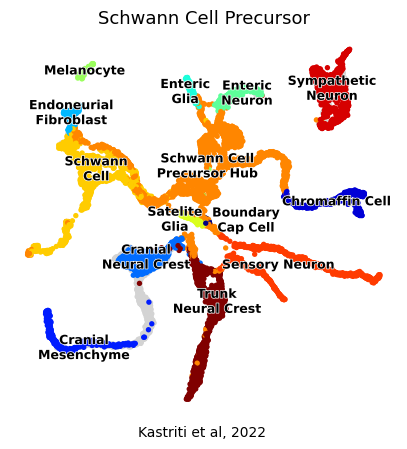

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.umap(adata, color = 'celltype', size = 60,
           legend_fontsize = 9, legend_loc = 'on data',
           na_in_legend = False, legend_fontoutline = 1,
           frameon = False, show = False, ax = ax)

label_dict = {'Endoneurial Fibroblast'     : 'Endoneurial\nFibroblast',
              'Sympathetic Neuron'         : 'Sympathetic\nNeuron',
              'Enteric Neuron'             : 'Enteric\nNeuron',
              'Enteric Glia'               : 'Enteric\nGlia',
              'Schwann Cell'               : 'Schwann\nCell',
              'Schwann Cell Precursor Hub' : 'Schwann Cell\nPrecursor Hub',
              'Cranial Neural Crest'       : 'Cranial\nNeural Crest',
              'Trunk Neural Crest'         : 'Trunk\nNeural Crest',
              'Cranial Mesenchyme'         : 'Cranial\nMesenchyme',
              'Satelite Glia'              : 'Satelite\nGlia',
              'Boundary Cap Cell'          : 'Boundary\nCap Cell'}

pos_dict = {'Enteric Neuron'     : (1, 0),
            'Enteric Glia'       : (-.5, 0),
            'Schwann Cell'       : (.75, .75),
            'Trunk Neural Crest' : (1, .5),
            'Cranial Mesenchyme' : (1.75, -.5),
            'Satelite Glia'      : (-1.5, 0),
            'Boundary Cap Cell'  : (3, 0)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df_summary.Name.values[0], size = 13)
ax.text(.33, -.05, df_summary.Study.values[0], transform = ax.transAxes)
fn = os.path.join(pth_fig, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')